In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import os

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\HasarangaEdirisinghe\Desktop\glaucoma\dataset"
CATEGORIES = ["Glaucoma_Negative", "Glaucoma_Positive"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")


[INFO] loading images...


In [ ]:

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [ ]:


# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)


In [ ]:

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [ ]:

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [ ]:

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])




[INFO] compiling model...


c:\Users\HasarangaEdirisinghe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=100)

[INFO] training head...
Epoch 1/100
16/16 [==============================] - 8s 516ms/step - loss: 0.5062 - accuracy: 0.7602 - val_loss: 0.4746 - val_accuracy: 0.8000
Epoch 2/100
16/16 [==============================] - 8s 495ms/step - loss: 0.5183 - accuracy: 0.7664 - val_loss: 0.4735 - val_accuracy: 0.8000
Epoch 3/100
16/16 [==============================] - 8s 492ms/step - loss: 0.5055 - accuracy: 0.7807 - val_loss: 0.4736 - val_accuracy: 0.8077
Epoch 4/100
16/16 [==============================] - 8s 486ms/step - loss: 0.5333 - accuracy: 0.7602 - val_loss: 0.4721 - val_accuracy: 0.7846
Epoch 5/100
16/16 [==============================] - 8s 483ms/step - loss: 0.5020 - accuracy: 0.7664 - val_loss: 0.4744 - val_accuracy: 0.7923
Epoch 6/100
16/16 [==============================] - 8s 489ms/step - loss: 0.5136 - accuracy: 0.7664 - val_loss: 0.4751 - val_accuracy: 0.7846
Epoch 7/100
16/16 [==============================] - 8s 489ms/step - loss: 0.5032 - accuracy: 0.7746 - val_loss: 0.475

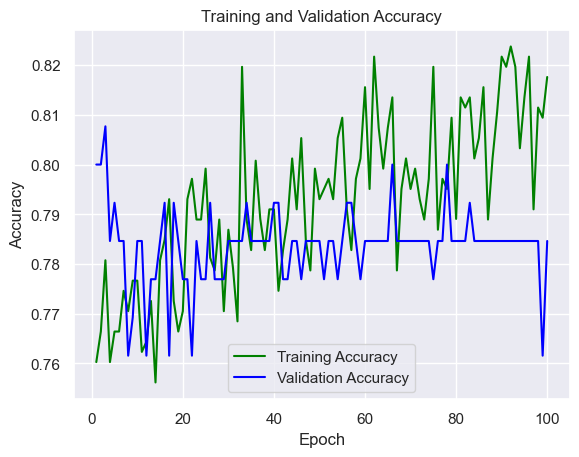

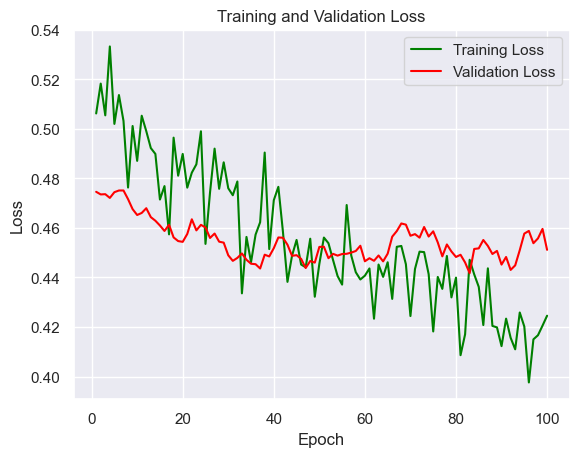

In [ ]:
# Plot the training and validation accuracy and loss
import seaborn as sns
sns.set()

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))



[INFO] evaluating network...
                   precision    recall  f1-score   support

Glaucoma_Negative       0.79      0.96      0.87        96
Glaucoma_Positive       0.71      0.29      0.42        34

         accuracy                           0.78       130
        macro avg       0.75      0.63      0.64       130
     weighted avg       0.77      0.78      0.75       130



In [ ]:

# serialize the model to disk
print("[INFO] saving mask detector model...")
try:
    model.save("glaucoma_detector.model", save_format="h5")
    print("[INFO] model saved successfully")
except Exception as e:
    print(f"[ERROR] {e}")

[INFO] saving mask detector model...
[INFO] model saved successfully
